                                 Open        High         Low       Close  \
Date                                                                        
2025-06-20 00:00:00-04:00  531.662915  532.961444  524.291189  526.239014   
2025-06-23 00:00:00-04:00  526.809998  532.169983  523.650024  531.650024   
2025-06-24 00:00:00-04:00  536.890015  540.700012  536.270020  539.780029   
2025-06-25 00:00:00-04:00  542.059998  543.309998  539.380005  541.159973   
2025-06-26 00:00:00-04:00  543.349976  546.669983  541.520020  546.219971   
2025-06-27 00:00:00-04:00  547.260010  549.989990  544.539978  548.090027   
2025-06-30 00:00:00-04:00  551.260010  552.799988  549.010010  551.640015   
2025-07-01 00:00:00-04:00  549.729980  550.710022  544.659973  546.989990   
2025-07-02 00:00:00-04:00  546.159973  551.000000  546.119995  550.799988   
2025-07-03 00:00:00-04:00  553.179993  557.200012  553.179993  556.219971   

                             Volume   SMA_short    SMA_long Signal  
Date  

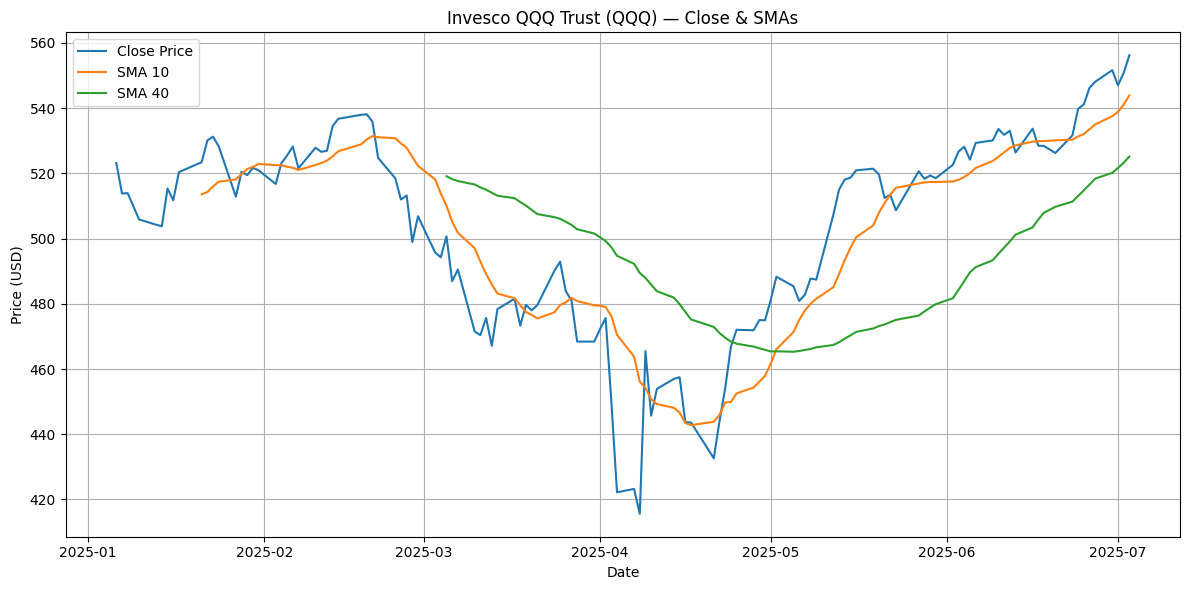

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

def price_history(symbol: str, period: str = '6mo') -> pd.DataFrame:
    ticker = yf.Ticker(symbol)
    df = ticker.history(period=period)
    return df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

def add_moving_averages(df: pd.DataFrame, short_window: int = 10, long_window: int = 40) -> pd.DataFrame:
    df['SMA_short'] = df['Close'].rolling(window=short_window).mean()
    df['SMA_long'] = df['Close'].rolling(window=long_window).mean()
    return df

def generate_signals(df: pd.DataFrame) -> pd.DataFrame:
    df['Signal'] = 'hold'
    buy_mask = (df['SMA_short'] > df['SMA_long']) & (df['SMA_short'].shift(1) <= df['SMA_long'].shift(1))
    df.loc[buy_mask, 'Signal'] = 'buy'
    sell_mask = (df['SMA_short'] < df['SMA_long']) & (df['SMA_short'].shift(1) >= df['SMA_long'].shift(1))
    df.loc[sell_mask, 'Signal'] = 'sell'
    return df

def backtest_signals(df: pd.DataFrame, initial_balance: float = 1000.0):
    balance = initial_balance
    shares = 0.0
    for price, signal in zip(df['Close'], df['Signal']):
        if signal == 'buy' and balance > 0:
            shares = balance / price
            balance = 0.0
        elif signal == 'sell' and shares > 0:
            balance = shares * price
            shares = 0.0
    return balance, shares

def plot_price_and_indicators(df: pd.DataFrame, title: str = '') -> None:
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Close'], label='Close Price')
    plt.plot(df.index, df['SMA_short'], label='SMA 10')
    plt.plot(df.index, df['SMA_long'], label='SMA 40')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    symbol = input("Введіть тікер: ").upper()
    ticker = yf.Ticker(symbol)
    info = ticker.info
    if not info or not info.get('longName'):
        print("Заданий тікер не існує")
        return
    company_name = info['longName']

    df = price_history(symbol)
    df = add_moving_averages(df)
    df = generate_signals(df)

    print(df.tail(10))

    ending_balance, ending_shares = backtest_signals(df)
    profit = ending_balance + ending_shares * df['Close'].iloc[-1] - 1000.0

    print(f'Початковий баланс: $1000')
    print(f'Кінцевий баланс: ${ending_balance:.2f}')
    print(f'Залишок акцій: {ending_shares:.4f}')
    print(f'Прибуток: ${profit:.2f}')
    plot_price_and_indicators(df, title=f'{company_name} ({symbol}) — Close & SMAs')

if __name__ == '__main__':
    main()